In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from collections import defaultdict
import pickle
import numpy as np

In [28]:
movies = pd.read_json('data/IMDB_movie_details_eng.json')
reviews = pd.read_json('data/IMDB_reviews.json', lines = True)

movies.movie_id = movies.movie_id.astype('str')
reviews.movie_id = reviews.movie_id.astype('str')

In [29]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1572 entries, 0 to 1571
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
 7   title          1572 non-null   object 
dtypes: float64(1), object(7)
memory usage: 110.5+ KB


In [30]:

movies.groupby('title').count()['movie_id'].sort_values(ascending = False).head(10)

title
Les Misérables                     2
Crash                              2
Total Recall                       2
Hercules                           2
Flatliners                         2
Oldboy                             2
The Three Musketeers               2
The Girl with the Dragon Tattoo    2
Fantastic Four                     2
Spirited Away                      1
Name: movie_id, dtype: int64

In [31]:
movie_doubles = movies.loc[movies.title.isin(['Les Misérables', 'Crash','Total Recall', 'Hercules', 'Flatliners', 'Oldboy', 'The Three Musketeers', 'The Girl with the Dragon Tattoo', 'Fantastic Four']), ['movie_id', 'title', 'release_date']]
movie_doubles

,movie_id,title,release_date
165,tt0119683,Les Misérables,1998-05-01
319,tt1267297,Hercules,2014-07-25
339,tt0100802,Total Recall,1990-06-01
394,tt1321511,Oldboy,2013-11-27
432,tt0108333,The Three Musketeers,1993-11-12
501,tt0099582,Flatliners,1990-08-10
795,tt1132620,The Girl with the Dragon Tattoo,2010-04-30
892,tt1509767,The Three Musketeers,2011-10-21
940,tt0364569,Oldboy,2003-11-21
1031,tt1386703,Total Recall,2012-08-03


They have the same title but different release dates => different movies.

In [32]:
movie_doubles.release_date = pd.to_datetime(movie_doubles.release_date)
movie_doubles['year'] = movie_doubles.release_date.dt.year

# concat title and year to get unique movie identifier like title(yyyy)
movie_doubles['title_year'] = movie_doubles.title + ' (' + movie_doubles.year.astype('str') + ')'

movie_doubles

,movie_id,title,release_date,year,title_year
165,tt0119683,Les Misérables,1998-05-01,1998,Les Misérables (1998)
319,tt1267297,Hercules,2014-07-25,2014,Hercules (2014)
339,tt0100802,Total Recall,1990-06-01,1990,Total Recall (1990)
394,tt1321511,Oldboy,2013-11-27,2013,Oldboy (2013)
432,tt0108333,The Three Musketeers,1993-11-12,1993,The Three Musketeers (1993)
501,tt0099582,Flatliners,1990-08-10,1990,Flatliners (1990)
795,tt1132620,The Girl with the Dragon Tattoo,2010-04-30,2010,The Girl with the Dragon Tattoo (2010)
892,tt1509767,The Three Musketeers,2011-10-21,2011,The Three Musketeers (2011)
940,tt0364569,Oldboy,2003-11-21,2003,Oldboy (2003)
1031,tt1386703,Total Recall,2012-08-03,2012,Total Recall (2012)


In [33]:
movies.loc[movies.movie_id.isin(list(movie_doubles.movie_id)), 'title'] = movie_doubles.title_year

In [34]:
movies.groupby('title').count()['movie_id'].sort_values(ascending = False).head(10)

title
10 Things I Hate About You           1
Spy Kids 2: Island of Lost Dreams    1
Spy                                  1
Spring Breakers                      1
Spotlight                            1
Split                                1
Spirited Away                        1
Spider-Man: Homecoming               1
Spider-Man 3                         1
Spider-Man 2                         1
Name: movie_id, dtype: int64

In [35]:
# map to null values the empty strings in the movies dataframe  
movies = movies.replace(r'^\s*$', np.nan, regex=True)

First reduce the whole set of reviews

In [36]:
reviews.review_date = pd.to_datetime(reviews.review_date)
reviews['year'] = reviews.review_date.dt.year
reviews = reviews[(reviews.year >= 2004) & (reviews.year <= 2017)]
reviews_stratified = reviews.groupby(['movie_id', 'is_spoiler'], group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)

# If needed, bring the grouping columns back
reviews = reviews_stratified.reset_index()


/var/folders/dr/d_wys8sx6dj_8v6ssg_x0_qc0000gp/T/ipykernel_3916/406249850.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews_stratified = reviews.groupby(['movie_id', 'is_spoiler'], group_keys=False).apply(


In [37]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117216 entries, 0 to 117215
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           117216 non-null  int64         
 1   review_date     117216 non-null  datetime64[ns]
 2   movie_id        117216 non-null  object        
 3   user_id         117216 non-null  object        
 4   is_spoiler      117216 non-null  bool          
 5   review_text     117216 non-null  object        
 6   rating          117216 non-null  int64         
 7   review_summary  117216 non-null  object        
 8   year            117216 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(2), object(4)
memory usage: 6.8+ MB


In [38]:
df = pd.merge(movies, reviews, on='movie_id', suffixes=('_movie', '_review'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117216 entries, 0 to 117215
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   movie_id        117216 non-null  object        
 1   plot_summary    117216 non-null  object        
 2   duration        117216 non-null  object        
 3   genre           117216 non-null  object        
 4   rating_movie    117216 non-null  float64       
 5   release_date    117216 non-null  object        
 6   plot_synopsis   110547 non-null  object        
 7   title           117216 non-null  object        
 8   index           117216 non-null  int64         
 9   review_date     117216 non-null  datetime64[ns]
 10  user_id         117216 non-null  object        
 11  is_spoiler      117216 non-null  bool          
 12  review_text     117216 non-null  object        
 13  rating_review   117216 non-null  int64         
 14  review_summary  117216 non-null  obj

## Understand all present characters

In [39]:
df['plot_summary'] = df['plot_summary'].astype(str)
df['plot_synopsis'] = df['plot_synopsis'].astype(str)
df['review_text'] = df['review_text'].astype(str)
df['review_summary  '] = df['plot_summary'].astype(str)

df['plot_summary'] = df['plot_summary'].apply(lambda x: x.strip())
df['plot_synopsis'] = df['plot_synopsis'].apply(lambda x: x.strip())
df['review_text'] = df['review_text'].apply(lambda x: x.strip())
df['review_summary  '] = df['plot_summary'].apply(lambda x: x.strip())

### Create dictionaries with char counts

#### Review Text

In [40]:
review_text_corpus = ' '.join(df['review_text'].values)

In [41]:
review_text_char = defaultdict(int)
for char in review_text_corpus:
    review_text_char[char] += 1


In [42]:
# show the top 20 dict values in ascending order 
review_text_char_viz = sorted(review_text_char.items(), key=lambda x: x[1])[:20]
review_text_char_viz

[('ẻ', 1),
 ('È', 1),
 ('😃', 1),
 ('🤣', 1),
 ('─', 1),
 ('К', 1),
 ('Ε', 1),
 ('😳', 1),
 ('¥', 1),
 ('⁉', 1),
 ('か', 1),
 ('た', 1),
 ('わ', 1),
 ('れ', 1),
 ('時', 1),
 ('😆', 1),
 ('👽', 1),
 ('к', 1),
 ('Ⅵ', 1),
 ('א', 1)]

Full of emojis and non alphanumerical characters!!!

In [43]:
len(review_text_char)

436

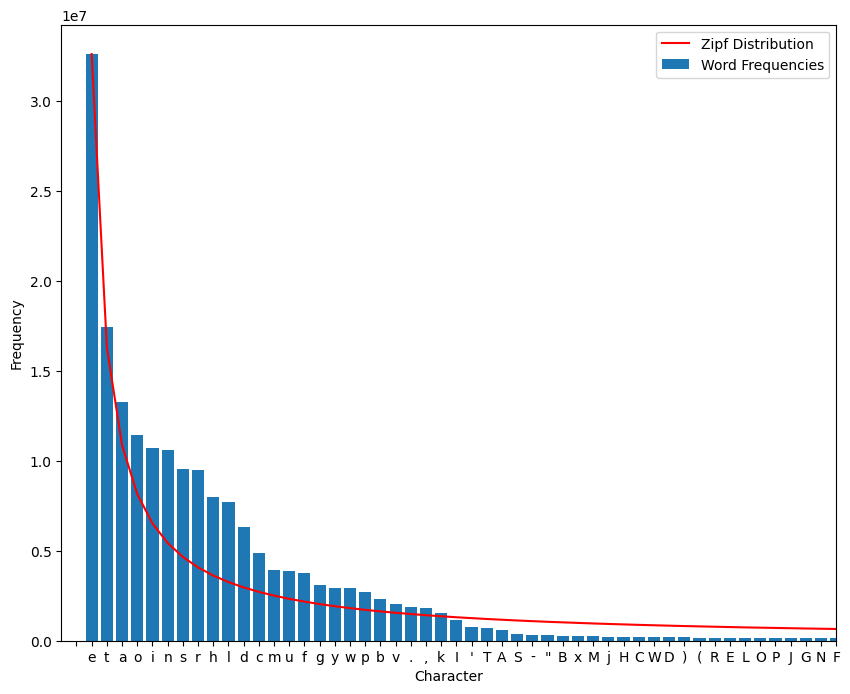

In [44]:
review_text_char_viz = sorted(review_text_char.items(), key=lambda x: x[1], reverse=True)#[1:] #remove the first as it is a space
# Extract word ranks and frequencies
ranks = np.arange(1, len(review_text_char_viz) + 1)
frequencies = [freq for _, freq in review_text_char_viz]

# plot the distribution of characters in the review text
plt.figure(figsize=(10, 8))
plt.bar(ranks, frequencies, label='Word Frequencies')
plt.plot(ranks, frequencies[0] / ranks, 'r-', label='Zipf Distribution')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(range(len(review_text_char_viz)), [char[0] for char in review_text_char_viz])
plt.xlim(-1, 50)
plt.legend()
plt.show()

Doesn't this resamble something??
hint. ZIPF!

## Cleaned Dataset

In [45]:
new_df = df.loc[:, ['movie_id', 'review_text', 'is_spoiler', 'title']]
new_df.head()
new_df.loc[df['review_text'].str.contains('@'), :]

,movie_id,review_text,is_spoiler,title
48,tt1204975,Last Vegas is the story of four lifetime frien...,True,Last Vegas
445,tt0443453,Borat is wonderful; he knows where he's going ...,False,Borat
548,tt0450259,"I saw this on December 2nd in La Canada, CA @ ...",False,Blood Diamond
647,tt0450259,Just saw this movie last night and I tell you ...,False,Blood Diamond
791,tt0435625,WOW .. Totally blew me away when i saw it last...,False,The Descent
...,...,...,...,...
115833,tt0103644,"After the horror filled excellence of Alien, a...",True,Alien 3
115955,tt0361748,The hyperbole being bandied about regarding th...,False,Inglourious Basterds
116285,tt1502712,I heard the rumors and read the reviews about ...,False,Fantastic Four (2015)
117027,tt1723811,Shame is a film about addiction. This is uncom...,True,Shame


In [46]:
def remove_meta(text):
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'\S*\.com\b', '', text)
    return text
import re

In [47]:
def decontracted(phrase, apostrophes = ["\'", "`", "´", "‘", "’", "′", "ʻ", "ˈ"]):
    # specific
    apos = '(' + '|'.join(apostrophes) + ')'
    phrase = re.sub(fr"won{apos}t", "will not", phrase)
    phrase = re.sub(fr"can{apos}t", "can not", phrase)

    # general
    phrase = re.sub(fr"n{apos}t", " not", phrase)
    phrase = re.sub(fr"{apos}re", " are", phrase)
    phrase = re.sub(fr"{apos}s", " is", phrase)
    phrase = re.sub(fr"{apos}d", " would", phrase)
    phrase = re.sub(fr"{apos}ll", " will", phrase)
    phrase = re.sub(fr"{apos}ve", " have", phrase)
    phrase = re.sub(fr"{apos}m", " am", phrase)
    return phrase

In [48]:
new_df['clean_text'] = new_df['review_text'].apply(remove_meta)
new_df['clean_text'] = new_df['clean_text'].apply(decontracted)

In [49]:
def keep_alfanumeric(text):
    return re.sub(r'[^a-zA-Z0-9 ]', ' ', text)

In [50]:
new_df['clean_text'] = new_df['clean_text'].apply(keep_alfanumeric)
new_df['clean_text'].values

array(['Patriot Games is a more than serviceable thriller  perhaps a bit out of date when viewing it now  but still a very effective good against evil piece  The source material is so dense and intricate it was always going to be hard to condense that into a 2 hour movie but I feel the makers manage to keep it fleshy whilst making the respective characters interesting and watchable  The acting on show is more than adequate  Harrison Ford is great in the role of Jack Ryan  he manages to portray him as a sensitive family man who can step up to the plate when things get ugly  and Anne Archer is solid enough as the wife and mother caught up in the web of nastiness unfolding The baddies are led by the brooding Sean Bean who is a little under written  whilst Richard Harris is sadly underused  but the action set pieces make their mark and thankfully we get a riveting final reel that cements the steady ride we have under taken  It is formulaic to a degree  but that is OK if the combined effort

In [51]:
while new_df['clean_text'].str.contains('  ').any():
    new_df['clean_text'] = new_df['clean_text'].str.replace('  ', ' ')

In [52]:
cleaned_reviews = new_df.loc[:, ['movie_id', 'clean_text', 'is_spoiler', 'title' ]]
cleaned_reviews.to_json('data/reduced_cleaned_reviews.json')